In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv(r"C:\Users\ktulu\OneDrive\Документы\ML - лабы\data\Dataset2.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

,Film,Oscar Year,Film Studio/Producer(s),Award,Year of Release,Movie Time,Movie Genre,IMDB Rating,IMDB Votes,Movie Info,...,Tomatometer Status,Tomatometer Rating,Tomatometer Count,Audience Status,Audience Rating,Audience Count,Tomatometer Top Critics Count,Tomatometer Fresh Critics Count,Tomatometer Rotten Critics Count,Film ID
0,Wings,1927/28,Famous Players-Lasky,Winner,1927,144,"Drama,Romance,War",7.5,"12,221","With World War I afoot, David Armstrong (Richa...",...,Certified-Fresh,93.0,46.0,Upright,78.0,3530.0,9.0,43.0,3.0,2becf7d5-a3de-46ab-ae45-abdd6b588067
1,7th Heaven,1927/28,Fox,Nominee,1927,110,"Drama,Romance",7.7,"3,439",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19ed3295-a878-4fd2-8e60-5cd7b5f93dad
2,The Racket,1927/28,The Caddo Company,Nominee,1928,84,"Crime,Drama,Film-Noir",6.7,"1,257",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3111c2d8-0908-4093-8ff3-99c89f2f2f08
3,The Broadway Melody,1928/29,Metro-Goldwyn-Mayer,Winner,1929,100,"Drama,Musical,Romance",5.7,"6,890","Vaudeville sisters ""Hank"" (Bessie Love) and Qu...",...,Rotten,33.0,24.0,Spilled,21.0,1813.0,7.0,8.0,16.0,de063f3f-2d35-4e1c-8636-6eb4c16bd236
4,Alibi,1928/29,Feature Productions,Nominee,1929,91,"Action,Crime,Romance",5.8,765,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,609887c2-877c-43a4-b88c-e40e31096a98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,Mank,2020,"Ceán Chaffin, Eric Roth, and Douglas Urbanski",Nominee,2020,131,"Biography,Comedy,Drama",6.9,"65,380",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47d4ae4f-e782-4cd9-9508-4a07302b1c1a
567,Minari,2020,Christina Oh,Nominee,2020,115,Drama,7.5,"57,976",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7262b3a8-214d-4205-985c-70e0860f3236
568,Promising Young Woman,2020,"Ben Browning, Ashley Fox, Emerald Fennell, and...",Nominee,2020,113,"Crime,Drama,Thriller",7.5,"122,269",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d64c669b-7a73-496a-bddb-19cb09264371
569,Sound of Metal,2020,Bert Hamelinck and Sacha Ben Harroche,Nominee,2019,120,"Drama,Music",7.8,"102,807",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,647357e9-c067-46bd-aaeb-24d4344ec124


Приведем имена признаков к стандартному виду

In [3]:
df = df.rename(columns={
    'Film': 'film','Oscar Year' : 'oscar_year','Film Studio/Producer(s)' : 'film_studio_producer','Award' : 'award','Year of Release' : 'year_of_release','Movie Time' : 'movie_time','Movie Genre' : 'movie_genre','IMDB Rating' : 'imdb_rating',
    'IMDB Votes' : 'imdb_votes','Movie Info' : 'movie_info','Critic Consensus' : 'critic_consensus','Content Rating' : 'content_rating','Directors' : 'directors','Authors' : 'authors','Actors' : 'actors','Original Release Date' : 'original_release_date',
    'Streaming Release Date' : 'streaming_release_date','Production Company' : 'production_company','Tomatometer Status' : 'tomatometer_status',
    'Tomatometer Rating' : 'tomatometer_rating','Tomatometer Count' : 'tomatometer_count','Audience Status' : 'audience_status',
    'Audience Rating' : 'audience_rating','Audience Count' : 'audience_count','Tomatometer Top Critics Count' : 'tomatometer_top_critics_count',
    'Tomatometer Fresh Critics Count' : 'tomatometer_fresh_critics_count','Tomatometer Rotten Critics Count' : 'tomatometer_rotten_critics_count',
    'Film ID' : 'film_id','Genres' : 'genres'
})

Изменим oscar_year, чтобы убрать слеш </br>
Переведем imdb_votes к типу int </br>
Все NaN в genres заменим на unknown, соединим с movie_genres и удалим genres

In [4]:
years = []
for year in df['oscar_year'].values:
    if '/' in year:
        years.append(int(year[:-3]))
        continue
    years.append(int(year))  
df['oscar_year'] = years

new_votes = []
for vote in df['imdb_votes'].values:
    vote = vote.replace(',', '')
    new_votes.append(int(vote))
    
df['imdb_votes'] = new_votes

df['genres'] = df['genres'].fillna('')
df['movie_genre'] = df['movie_genre'] +  df['genres']
del df['genres']

Пропущенные значения контент-рейтинга заполним средней оценкой рейтинга - от 13 без сопровождения взрослых

In [5]:
df['content_rating'].fillna('NR-13', inplace=True)

In [6]:
x = lambda x: x.mode().iat[0] if x.notna().any() else 'unknown'

group = df.groupby('film_studio_producer')['production_company'].transform(x)
df['production_company'].fillna(group, inplace=True)


В этих категориальных признаках заменим все пропущенные значения на unknown 

In [7]:
columns = ['critic_consensus', 'movie_info', 'authors', 'actors', 'directors']
for column in columns:
    df[column].fillna('unknown', inplace=True)

year_of_release и original_release_date - одинковые столбцы, поэтому удалим последний

In [8]:
df.drop('original_release_date', axis=1, inplace=True)

In [9]:
dict_cond = {'Winner': 1,
             'Nominee': 0}
df['award'] = df['award'].map(dict_cond)

Вычислим среднее значение от релиза до выпуска и прибавим их к дате релиза, если, конечно, это значение не превышает 2021, ведь фильмы уже выпустились.

In [10]:
data = df[['year_of_release', 'streaming_release_date']]
year_of_streaming_release = np.array([])
for index, row in data.iterrows():
    year_of_release = row['year_of_release']
    streaming_release_date = row['streaming_release_date']
    if streaming_release_date is np.nan:
        continue
    # print(int(streaming_release_date[:4]), year_of_release)
    year_of_streaming_release = np.append(year_of_streaming_release, int(int(streaming_release_date[:4]) - year_of_release))
year_of_streaming_release
mean_between_release_striming = round(np.mean(year_of_streaming_release))

array_streaming_release_date = []
for index, row in data.iterrows():
    year_of_release = row['year_of_release']
    streaming_release_date = row['streaming_release_date']
    if streaming_release_date is np.nan:
        streaming_release_date = year_of_release + mean_between_release_striming
        if streaming_release_date > 2021:
            streaming_release_date = int(year_of_release)
    else:
        streaming_release_date = int(streaming_release_date[:4])
    array_streaming_release_date = np.append(array_streaming_release_date, streaming_release_date)
df['streaming_release_date'] = array_streaming_release_date
df['streaming_release_date'] = df['streaming_release_date'].astype(int)
df = df.rename(columns={'streaming_release_date':'streaming_release_year'})

Заполним численные признаки mode или 0, а категориальные mode или unknown, связывая их с другими признаками.

In [11]:
x = lambda x: x.mode().iat[0] if x.notna().any() else 0
group = df.groupby('imdb_rating')['audience_rating'].transform(x)
df['audience_rating'].fillna(group, inplace=True)

group = df.groupby('imdb_rating')['tomatometer_rating'].transform(x)
df['tomatometer_rating'].fillna(group, inplace=True)

In [12]:
y = lambda y: y.mode().iat[0] if y.notna().any() else 'unknown'
group = df.groupby('tomatometer_rating')['tomatometer_status'].transform(y)
df['tomatometer_status'].fillna(group, inplace=True)

group = df.groupby('tomatometer_status')['audience_status'].transform(y)
df['audience_status'].fillna(group, inplace=True)

In [13]:
group = df.groupby('tomatometer_status')['tomatometer_top_critics_count'].transform(x)
df['tomatometer_top_critics_count'].fillna(group, inplace=True)

group = df.groupby('tomatometer_status')['tomatometer_fresh_critics_count'].transform(x)
df['tomatometer_fresh_critics_count'].fillna(group, inplace=True)

group = df.groupby('tomatometer_status')['tomatometer_rotten_critics_count'].transform(x)
df['tomatometer_rotten_critics_count'].fillna(group, inplace=True)

In [14]:
group = df.groupby('imdb_votes')['tomatometer_count'].transform(x)
df['tomatometer_count'].fillna(group, inplace=True)

group = df.groupby('imdb_votes')['audience_count'].transform(x)
df['audience_count'].fillna(group, inplace=True)

Проверим на дубликаты

In [15]:
df.duplicated().sum()

0

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   film                              571 non-null    object 
 1   oscar_year                        571 non-null    int64  
 2   film_studio_producer              571 non-null    object 
 3   award                             571 non-null    int64  
 4   year_of_release                   571 non-null    int64  
 5   movie_time                        571 non-null    int64  
 6   movie_genre                       571 non-null    object 
 7   imdb_rating                       571 non-null    float64
 8   imdb_votes                        571 non-null    int64  
 9   movie_info                        571 non-null    object 
 10  critic_consensus                  571 non-null    object 
 11  content_rating                    571 non-null    object 
 12  director

In [17]:
df.describe()

,oscar_year,award,year_of_release,movie_time,imdb_rating,imdb_votes,streaming_release_year,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,571.000000,571.000000,571.000000,571.000000,571.000000,5.710000e+02,571.000000,571.000000,571.000000,571.000000,5.710000e+02,571.000000,571.000000,571.000000
mean,1973.362522,0.162872,1973.357268,124.894921,7.570403,2.084804e+05,2008.971979,86.087566,85.106830,80.490368,3.962644e+05,18.007005,83.443082,9.926445
std,29.368379,0.369573,29.315738,26.322817,0.559652,3.423499e+05,13.512408,14.087049,114.728256,13.977218,3.183439e+06,20.318688,99.134455,17.500021
min,1927.000000,0.000000,1927.000000,66.000000,5.600000,1.800000e+01,1965.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,1944.000000,0.000000,1944.000000,107.000000,7.300000,9.660500e+03,2010.500000,82.000000,7.000000,76.000000,4.830000e+02,4.000000,17.000000,2.000000
50%,1973.000000,0.000000,1972.000000,121.000000,7.600000,5.899600e+04,2015.000000,90.000000,37.000000,84.000000,1.100100e+04,9.000000,52.000000,3.000000
75%,2001.000000,0.000000,2001.000000,136.500000,7.900000,2.594290e+05,2016.000000,95.000000,95.500000,89.000000,7.009000e+04,26.000000,88.000000,12.000000
max,2020.000000,1.000000,2021.000000,238.000000,9.300000,2.452594e+06,2021.000000,100.000000,574.000000,98.000000,3.579764e+07,69.000000,495.000000,182.000000


## Начало гистограмм

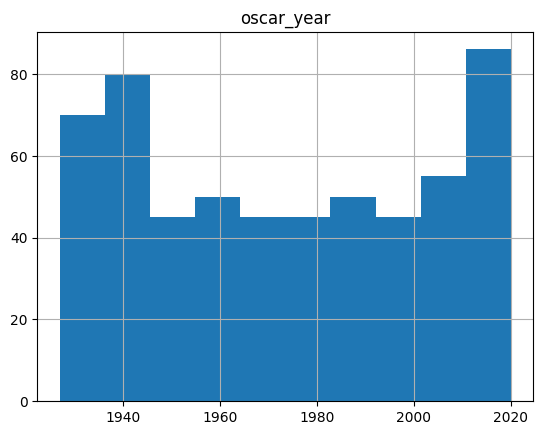

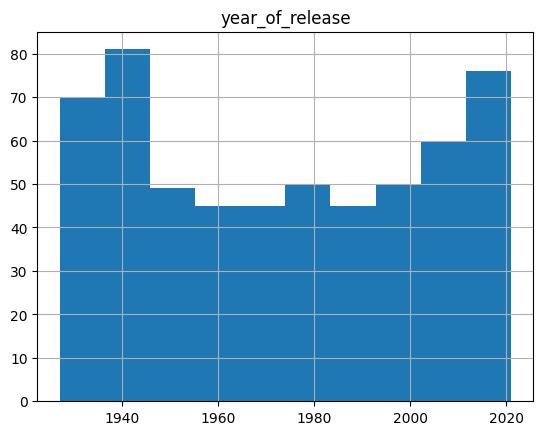

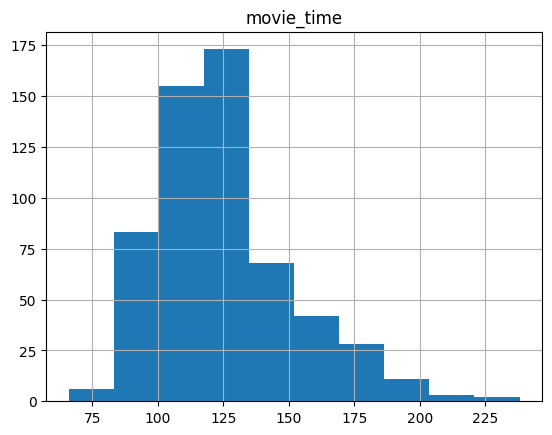

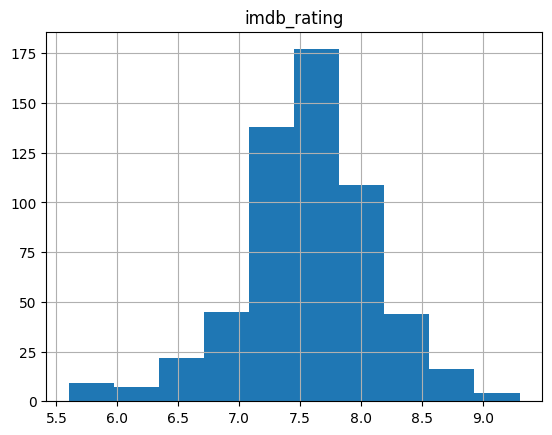

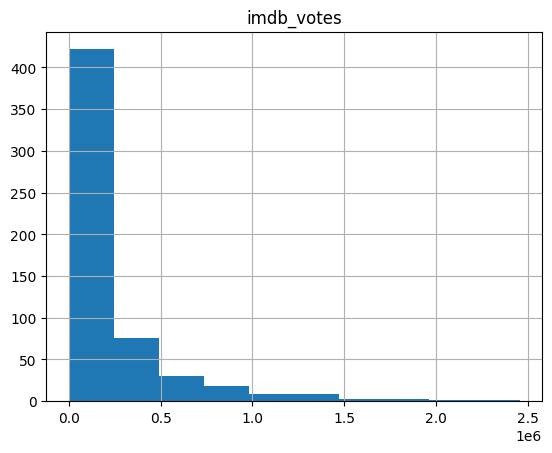

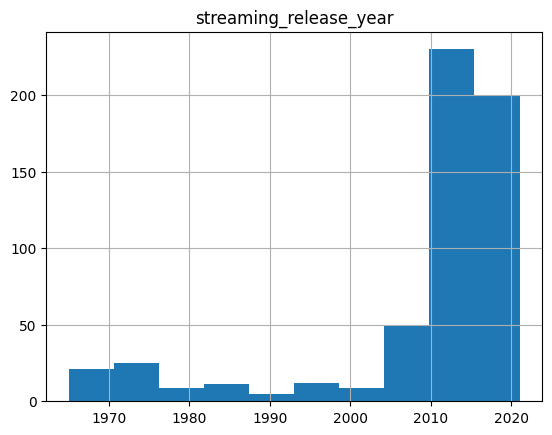

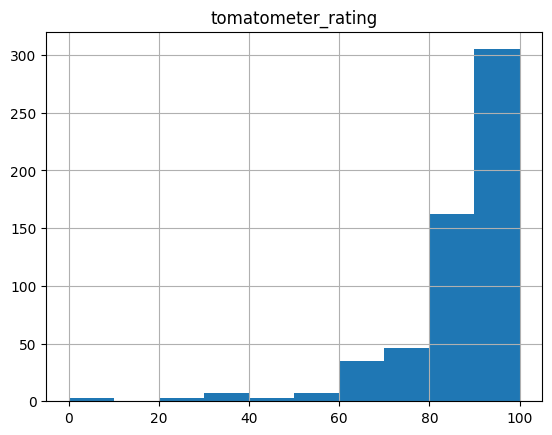

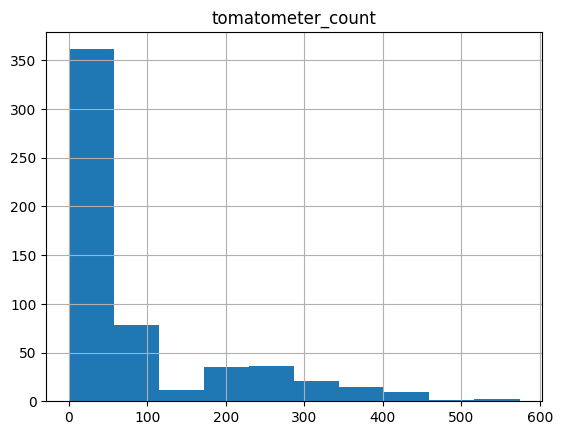

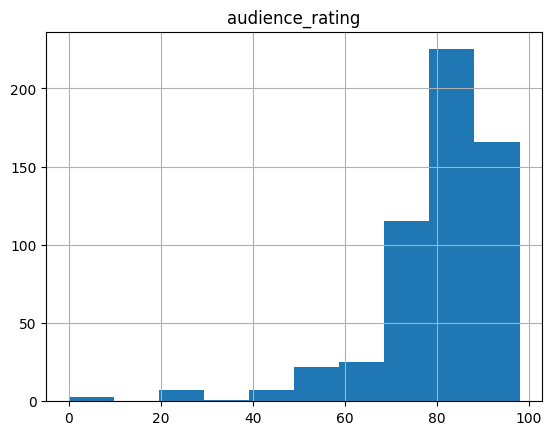

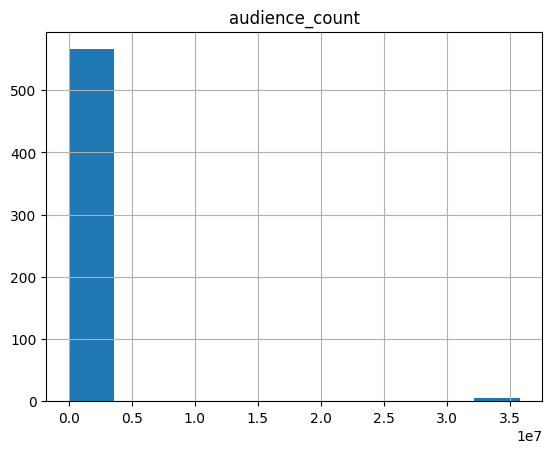

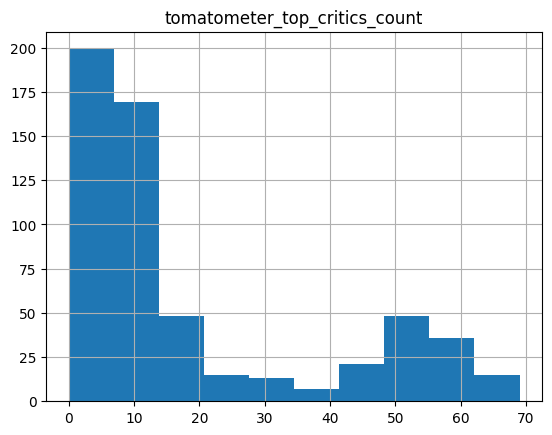

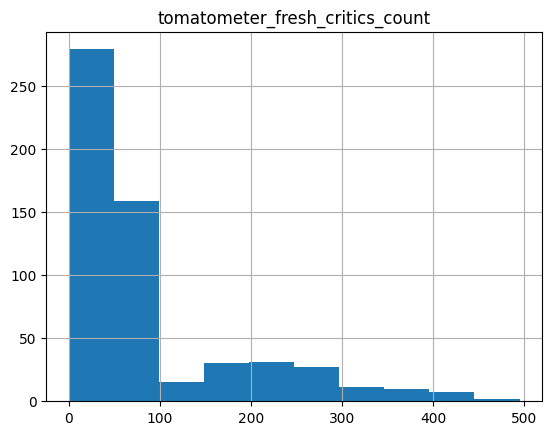

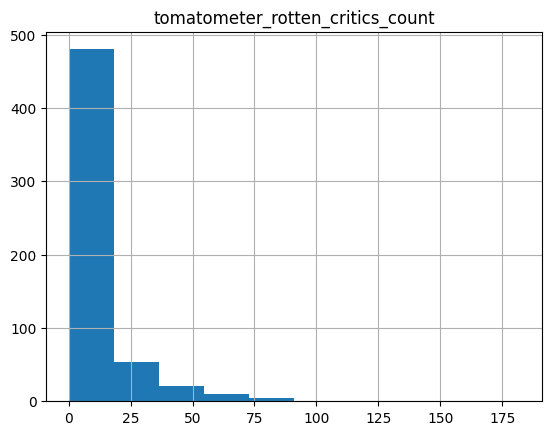

In [18]:
columns = ['oscar_year',
           'year_of_release','movie_time','imdb_rating','imdb_votes','streaming_release_year','tomatometer_rating','tomatometer_count',
           'audience_rating','audience_count','tomatometer_top_critics_count','tomatometer_fresh_critics_count','tomatometer_rotten_critics_count']
for column in columns:
    df.hist(column)

In [19]:
outlier = df[['oscar_year',
           'year_of_release','movie_time','imdb_rating','imdb_votes','streaming_release_year','tomatometer_rating','tomatometer_count',
           'audience_rating','audience_count','tomatometer_top_critics_count','tomatometer_fresh_critics_count','tomatometer_rotten_critics_count']]
outlier

,oscar_year,year_of_release,movie_time,imdb_rating,imdb_votes,streaming_release_year,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,1927,1927,144,7.5,12221,2017,93.0,46.0,78.0,3530.0,9.0,43.0,3.0
1,1927,1927,110,7.7,3439,1965,93.0,0.0,87.0,0.0,9.0,56.0,2.0
2,1927,1928,84,6.7,1257,1966,62.0,0.0,50.0,0.0,0.0,6.0,1.0
3,1928,1929,100,5.7,6890,2017,33.0,24.0,21.0,1813.0,7.0,8.0,16.0
4,1928,1929,91,5.8,765,1967,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,2020,2020,131,6.9,65380,2020,80.0,0.0,72.0,0.0,9.0,56.0,2.0
567,2020,2020,115,7.5,57976,2020,93.0,0.0,83.0,0.0,9.0,56.0,2.0
568,2020,2020,113,7.5,122269,2020,93.0,0.0,83.0,0.0,9.0,56.0,2.0
569,2020,2019,120,7.8,102807,2019,96.0,0.0,89.0,0.0,9.0,56.0,2.0


In [20]:
Q1 = outlier.quantile(0.25)
Q3 = outlier.quantile(0.75)
IQR = Q3-Q1
data_filtered = outlier[~((outlier < (Q1 - 1.5 * IQR)) |(outlier > (Q3 + 1.5 * IQR))).any(axis=1)]
data_filtered

,oscar_year,year_of_release,movie_time,imdb_rating,imdb_votes,streaming_release_year,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,1927,1927,144,7.5,12221,2017,93.0,46.0,78.0,3530.0,9.0,43.0,3.0
9,1929,1930,87,7.1,2079,2012,75.0,8.0,69.0,323.0,0.0,6.0,2.0
18,1931,1932,112,7.4,18314,2016,86.0,42.0,77.0,7014.0,10.0,36.0,6.0
21,1931,1931,86,7.3,3003,2017,90.0,10.0,74.0,617.0,2.0,9.0,1.0
27,1932,1933,89,7.4,11342,2012,96.0,25.0,74.0,7561.0,4.0,24.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,2020,2020,131,6.9,65380,2020,80.0,0.0,72.0,0.0,9.0,56.0,2.0
567,2020,2020,115,7.5,57976,2020,93.0,0.0,83.0,0.0,9.0,56.0,2.0
568,2020,2020,113,7.5,122269,2020,93.0,0.0,83.0,0.0,9.0,56.0,2.0
569,2020,2019,120,7.8,102807,2019,96.0,0.0,89.0,0.0,9.0,56.0,2.0


In [21]:
index_list = list(data_filtered.index.values)
data_filtered = df[df.index.isin(index_list)]
data_filtered.head()

,film,oscar_year,film_studio_producer,award,year_of_release,movie_time,movie_genre,imdb_rating,imdb_votes,movie_info,...,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,film_id
0,Wings,1927,Famous Players-Lasky,1,1927,144,"Drama,Romance,WarAction & Adventure, Classics",7.5,12221,"With World War I afoot, David Armstrong (Richa...",...,Certified-Fresh,93.0,46.0,Upright,78.0,3530.0,9.0,43.0,3.0,2becf7d5-a3de-46ab-ae45-abdd6b588067
9,The Big House,1929,Cosmopolitan,0,1930,87,"Crime,Drama,ThrillerClassics, Drama",7.1,2079,"After being convicted of manslaughter, drunk d...",...,Fresh,75.0,8.0,Upright,69.0,323.0,0.0,6.0,2.0,297aa285-29d7-4a22-b833-c5632ab3e562
18,Grand Hotel,1931,Metro-Goldwyn-Mayer,1,1932,112,"Drama,RomanceClassics, Drama, Romance",7.4,18314,"At a luxurious Berlin hotel between the wars, ...",...,Certified-Fresh,86.0,42.0,Upright,77.0,7014.0,10.0,36.0,6.0,be69f946-6adc-47e4-8491-79d6c033f59d
21,The Champ,1931,Metro-Goldwyn-Mayer,0,1931,86,"Drama,SportClassics, Drama, Kids & Family",7.3,3003,Champ (Wallace Beery) is a down-on-his-luck bo...,...,Fresh,90.0,10.0,Upright,74.0,617.0,2.0,9.0,1.0,c8994348-093e-4e22-8ffe-6ad3332a2bab
27,42nd Street,1932,Warner Bros.,0,1933,89,"Comedy,Drama,MusicalMusical & Performing Arts",7.4,11342,When revered Broadway director Julian Marsh (W...,...,Fresh,96.0,25.0,Upright,74.0,7561.0,4.0,24.0,1.0,1ad59370-1ed5-4d3a-a8c4-8571f95da168


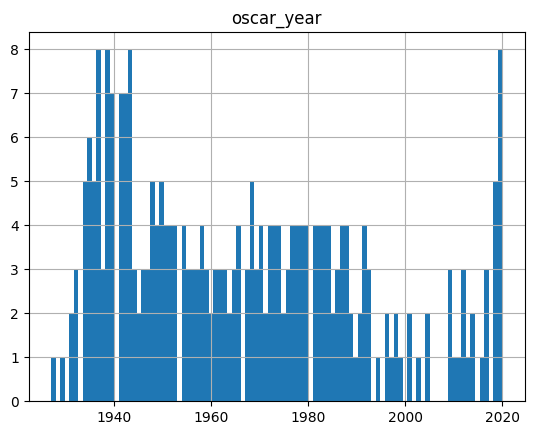

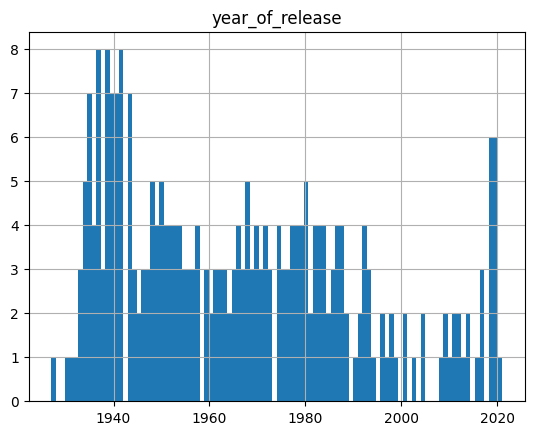

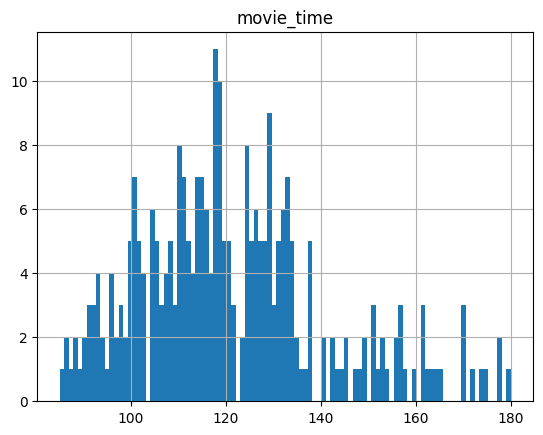

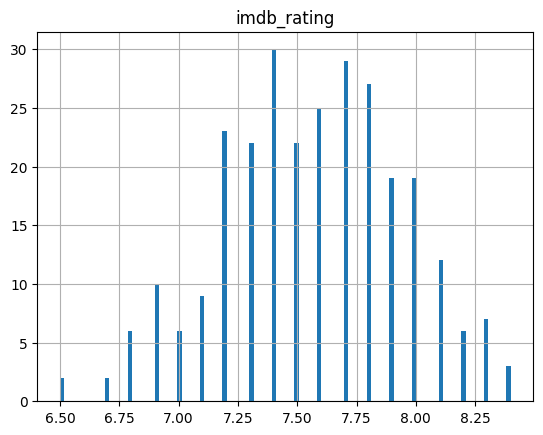

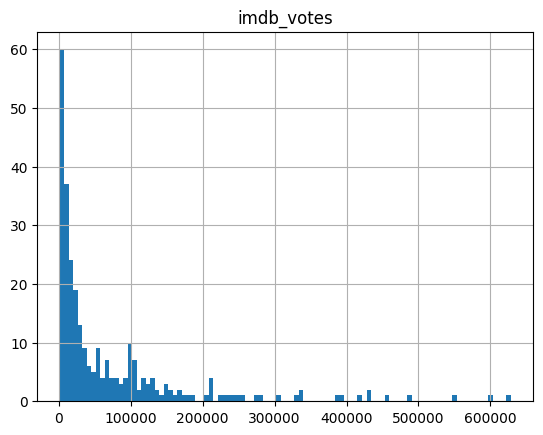

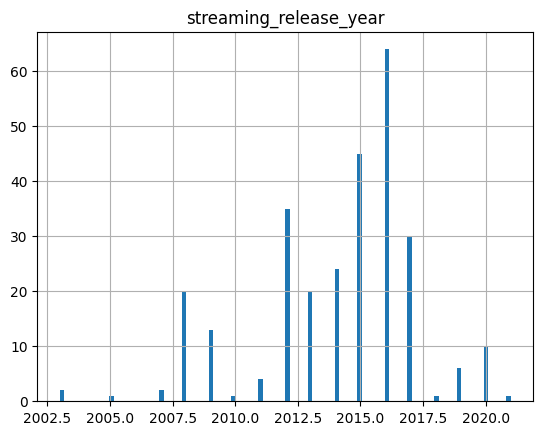

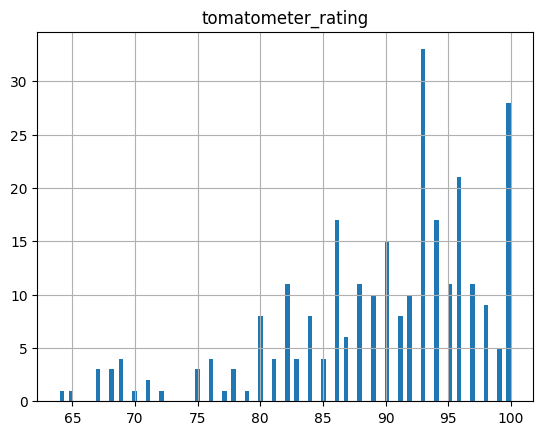

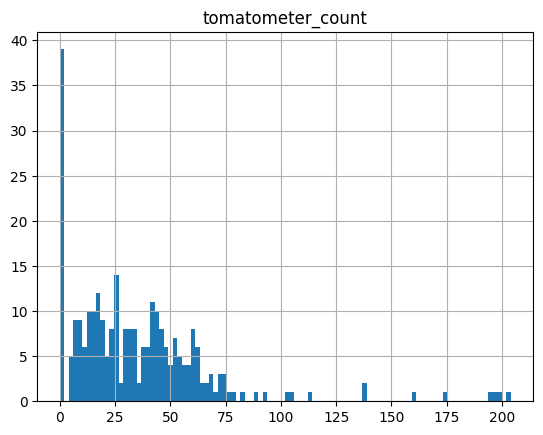

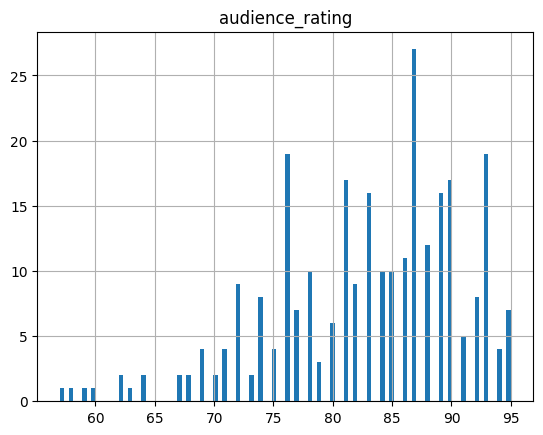

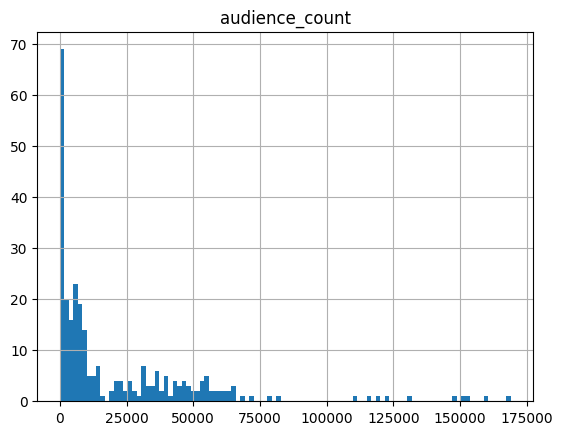

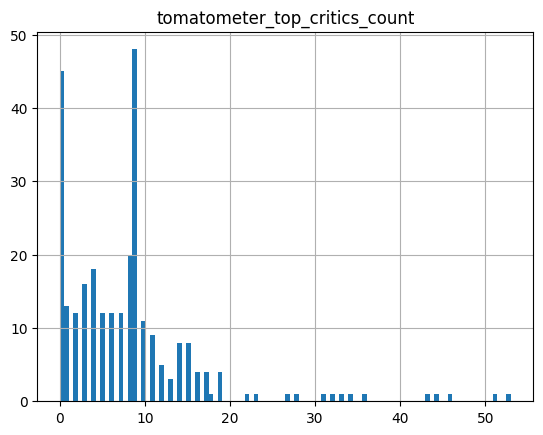

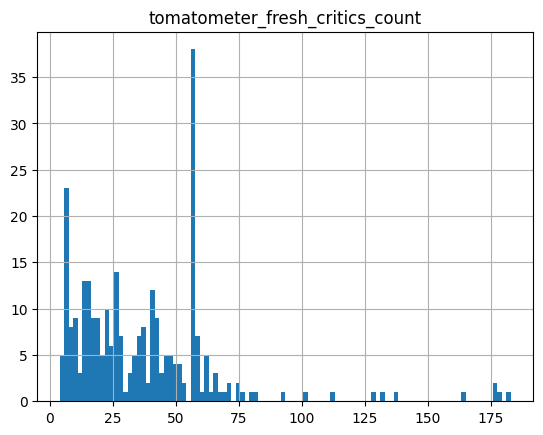

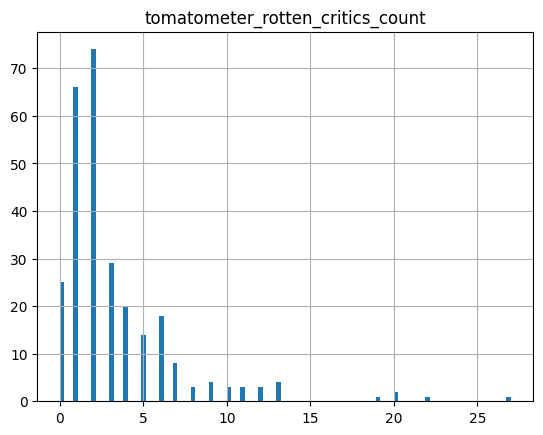

In [22]:
filter_outlier = data_filtered[['oscar_year',
           'year_of_release','movie_time','imdb_rating','imdb_votes','streaming_release_year','tomatometer_rating','tomatometer_count',
           'audience_rating','audience_count','tomatometer_top_critics_count','tomatometer_fresh_critics_count','tomatometer_rotten_critics_count']]

for col in filter_outlier:
    data_filtered.hist(col, bins=100)

## Начинаем сравнимать гистограммы

In [23]:
['tomatometer_rating','tomatometer_count',
           'audience_rating','audience_count','tomatometer_top_critics_count','tomatometer_fresh_critics_count','tomatometer_rotten_critics_count']

['tomatometer_rating',
 'tomatometer_count',
 'audience_rating',
 'audience_count',
 'tomatometer_top_critics_count',
 'tomatometer_fresh_critics_count',
 'tomatometer_rotten_critics_count']

In [24]:
def print_hist(feature):
    print(df.hist(feature, bins=100))
    print(data_filtered.hist(feature, bins=100))

[[<Axes: title={'center': 'oscar_year'}>]]
[[<Axes: title={'center': 'oscar_year'}>]]


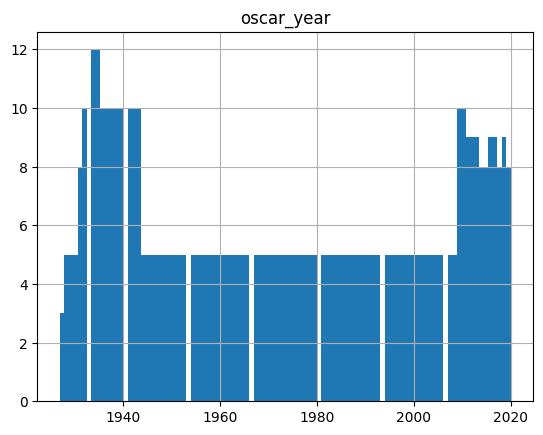

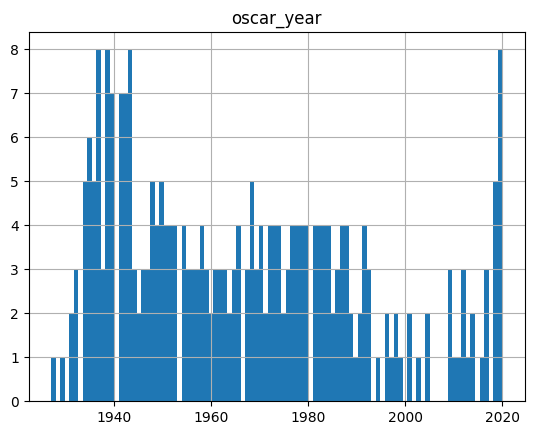

In [25]:
print_hist('oscar_year')

[[<Axes: title={'center': 'year_of_release'}>]]
[[<Axes: title={'center': 'year_of_release'}>]]


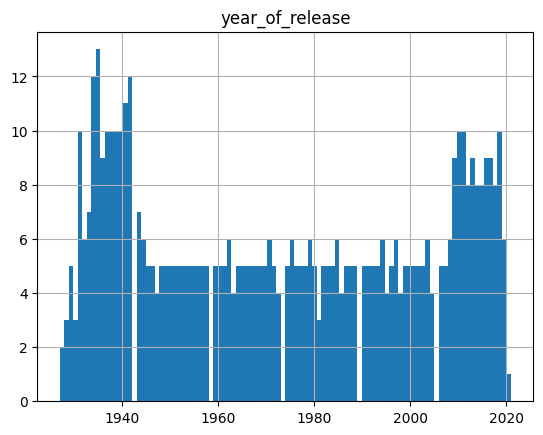

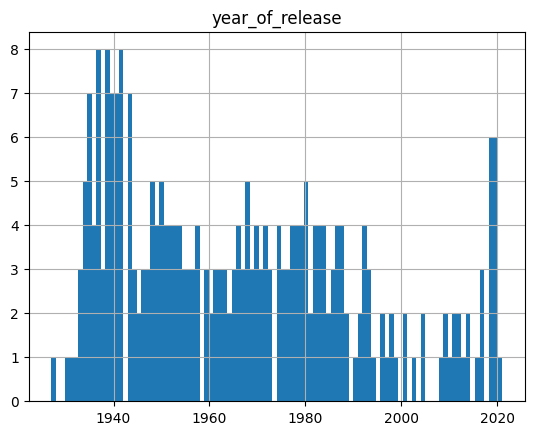

In [26]:
print_hist('year_of_release')

[[<Axes: title={'center': 'movie_time'}>]]
[[<Axes: title={'center': 'movie_time'}>]]


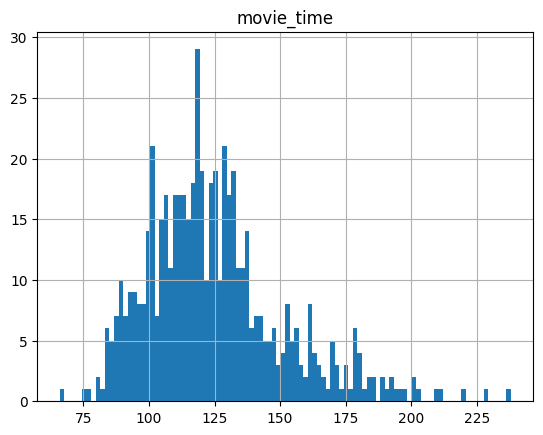

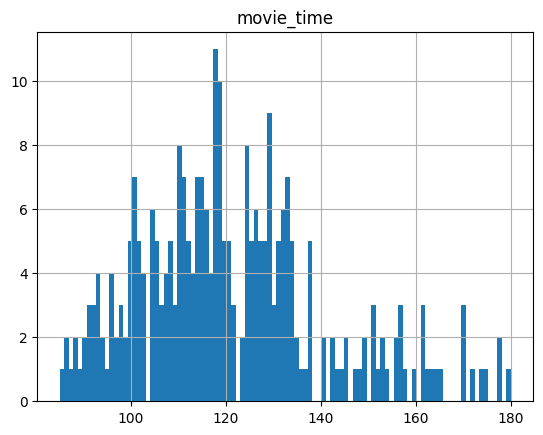

In [27]:
print_hist('movie_time')

[[<Axes: title={'center': 'imdb_rating'}>]]
[[<Axes: title={'center': 'imdb_rating'}>]]


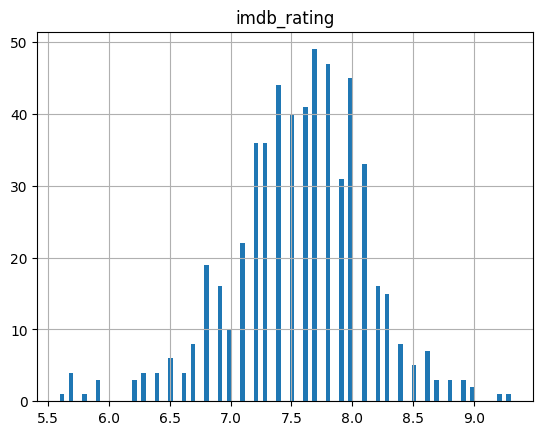

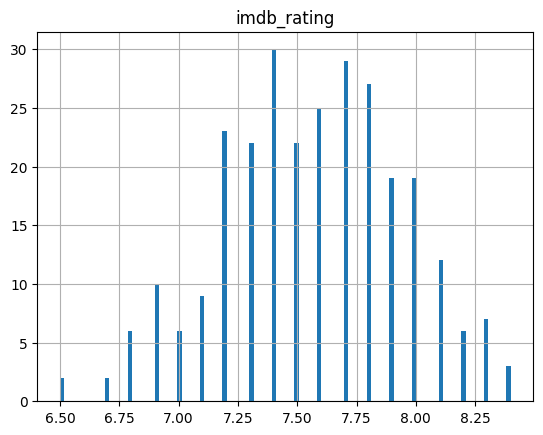

In [28]:
print_hist('imdb_rating')

[[<Axes: title={'center': 'imdb_votes'}>]]
[[<Axes: title={'center': 'imdb_votes'}>]]


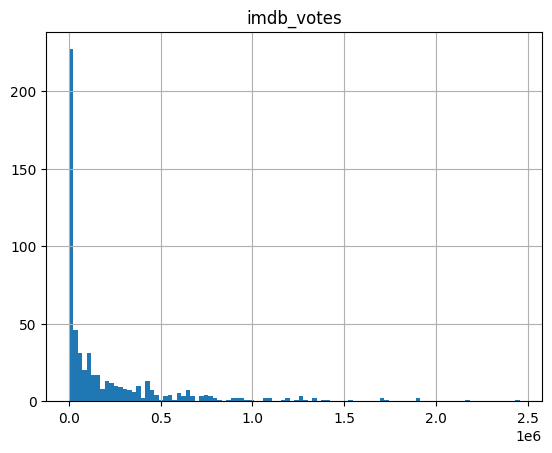

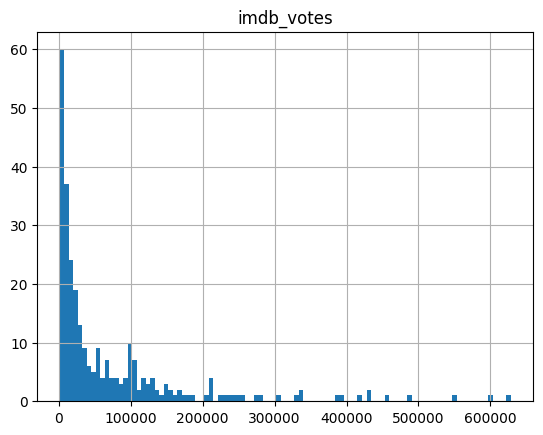

In [29]:
print_hist('imdb_votes')

[[<Axes: title={'center': 'streaming_release_year'}>]]
[[<Axes: title={'center': 'streaming_release_year'}>]]


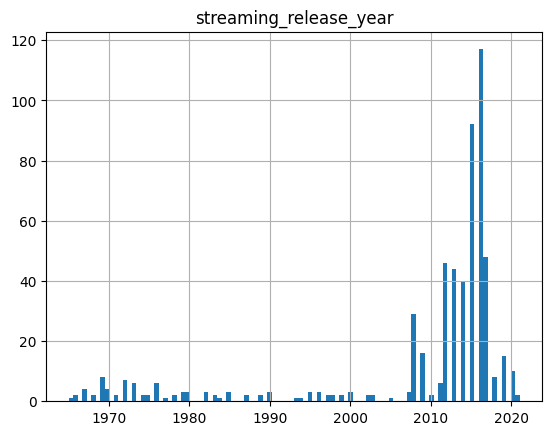

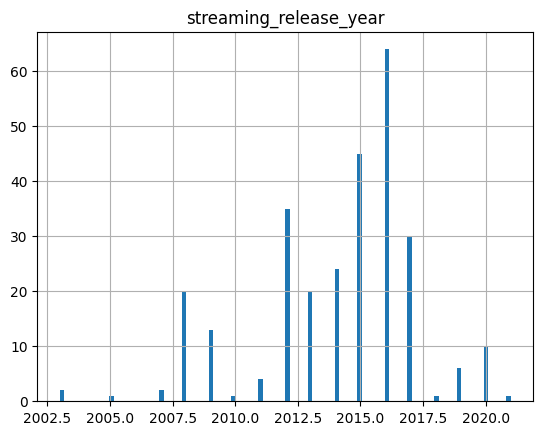

In [30]:
print_hist('streaming_release_year')

[[<Axes: title={'center': 'tomatometer_rating'}>]]
[[<Axes: title={'center': 'tomatometer_rating'}>]]


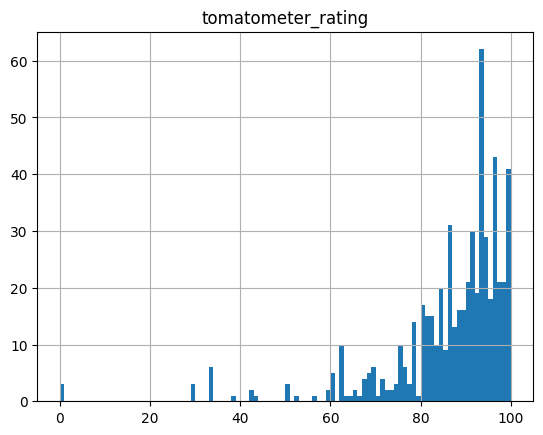

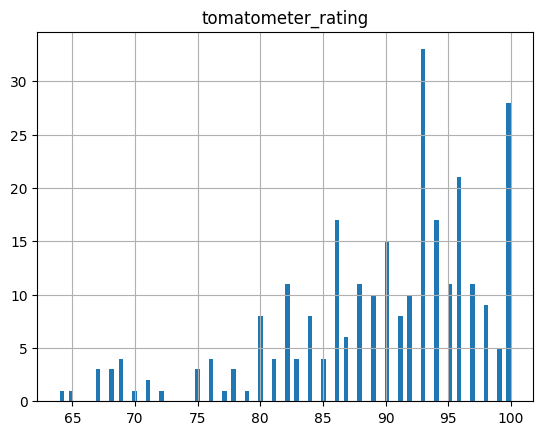

In [31]:
print_hist('tomatometer_rating')

[[<Axes: title={'center': 'tomatometer_count'}>]]
[[<Axes: title={'center': 'tomatometer_count'}>]]


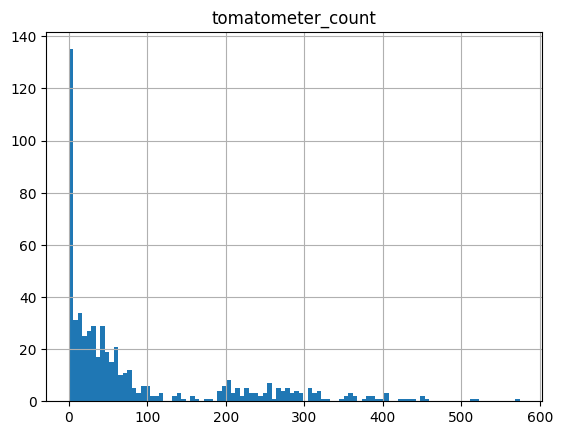

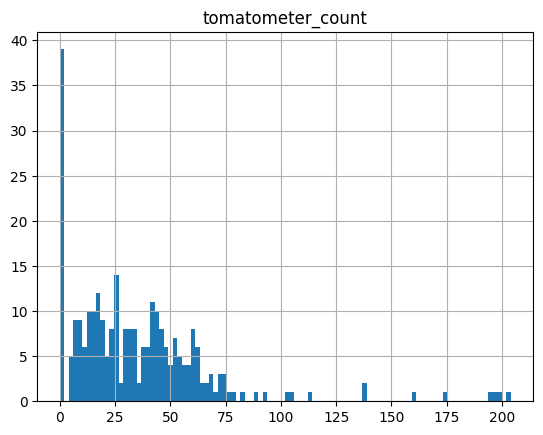

In [32]:
print_hist('tomatometer_count')

[[<Axes: title={'center': 'audience_rating'}>]]
[[<Axes: title={'center': 'audience_rating'}>]]


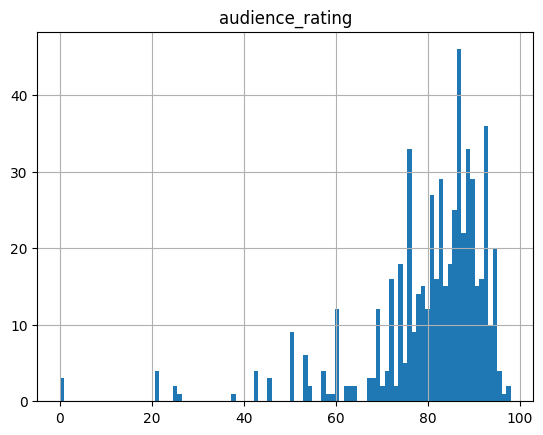

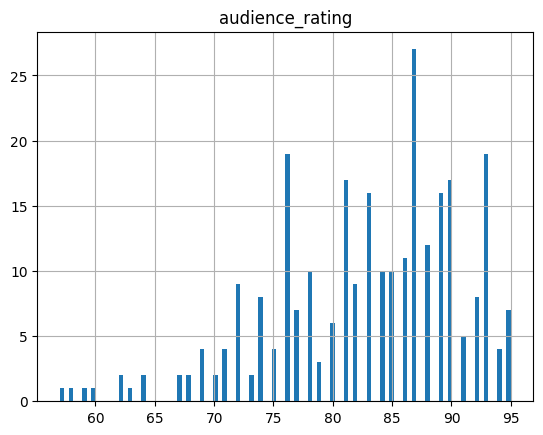

In [33]:
print_hist('audience_rating')

[[<Axes: title={'center': 'audience_count'}>]]
[[<Axes: title={'center': 'audience_count'}>]]


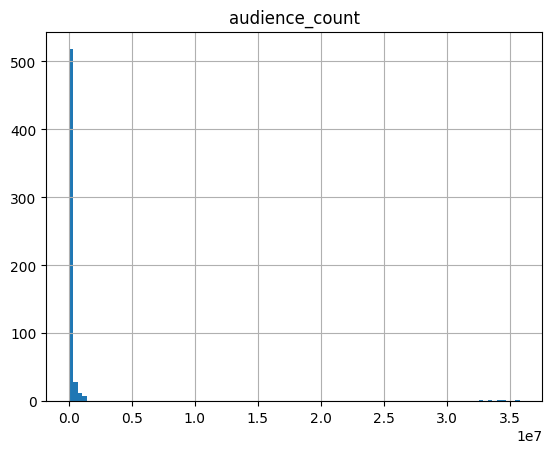

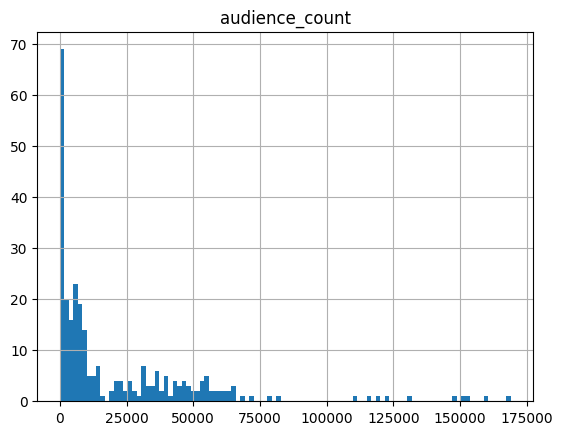

In [34]:
print_hist('audience_count')

[[<Axes: title={'center': 'tomatometer_top_critics_count'}>]]
[[<Axes: title={'center': 'tomatometer_top_critics_count'}>]]


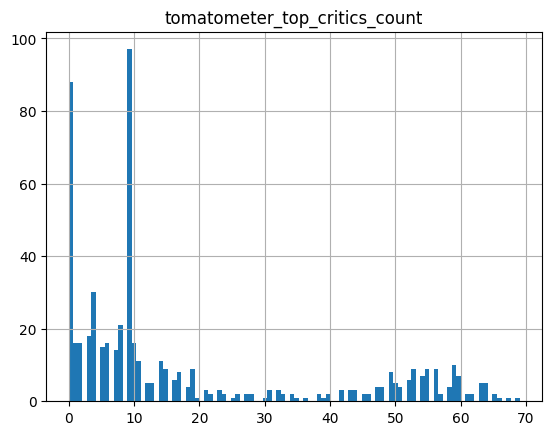

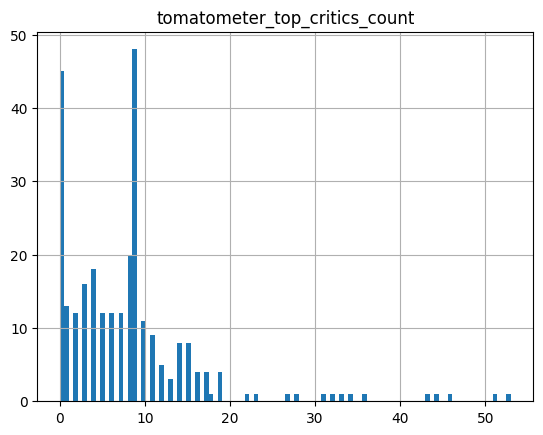

In [35]:
print_hist('tomatometer_top_critics_count')

[[<Axes: title={'center': 'tomatometer_fresh_critics_count'}>]]
[[<Axes: title={'center': 'tomatometer_fresh_critics_count'}>]]


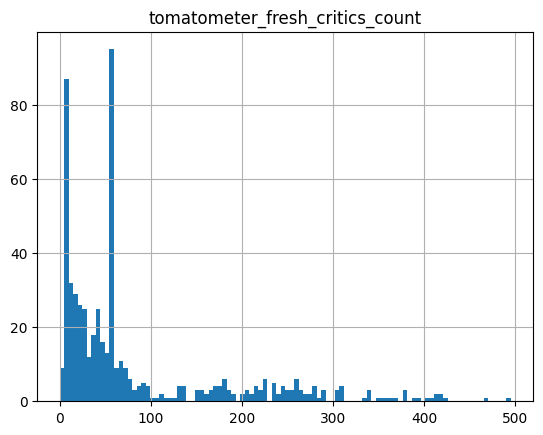

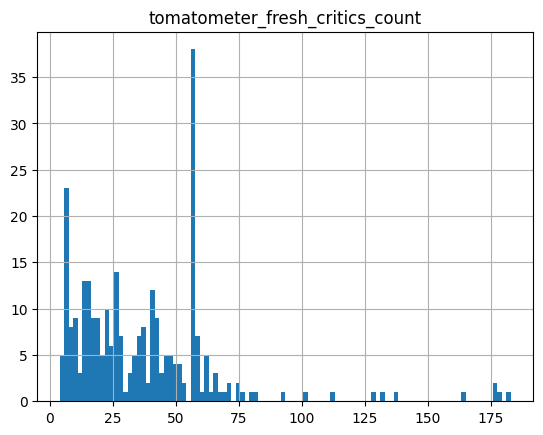

In [36]:
print_hist('tomatometer_fresh_critics_count')

[[<Axes: title={'center': 'tomatometer_rotten_critics_count'}>]]
[[<Axes: title={'center': 'tomatometer_rotten_critics_count'}>]]


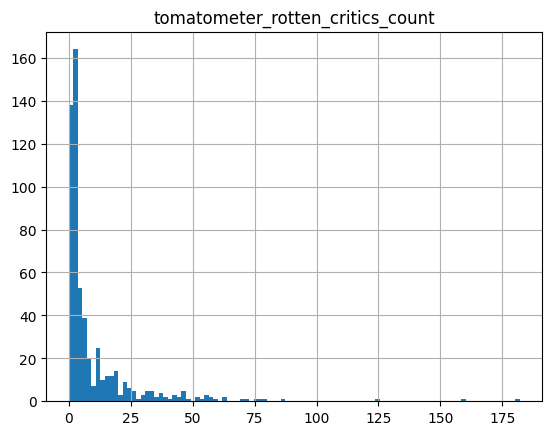

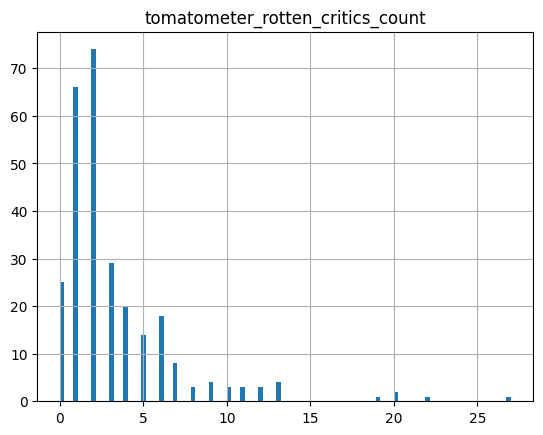

In [37]:
print_hist('tomatometer_rotten_critics_count')

In [38]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 279 entries, 0 to 570
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   film                              279 non-null    object 
 1   oscar_year                        279 non-null    int64  
 2   film_studio_producer              279 non-null    object 
 3   award                             279 non-null    int64  
 4   year_of_release                   279 non-null    int64  
 5   movie_time                        279 non-null    int64  
 6   movie_genre                       279 non-null    object 
 7   imdb_rating                       279 non-null    float64
 8   imdb_votes                        279 non-null    int64  
 9   movie_info                        279 non-null    object 
 10  critic_consensus                  279 non-null    object 
 11  content_rating                    279 non-null    object 
 12  directors    

In [39]:
imdb_rating = data_filtered.pivot_table(values='imdb_rating', index='content_rating', aggfunc='count')
imdb_rating.sort_values(ascending=False, by='imdb_rating')
imdb_rating = imdb_rating.reset_index()
imdb_rating

,content_rating,imdb_rating
0,G,33
1,NR,91
2,NR-13,39
3,PG,56
4,PG-13,11
5,R,49


<Axes: xlabel='content_rating'>

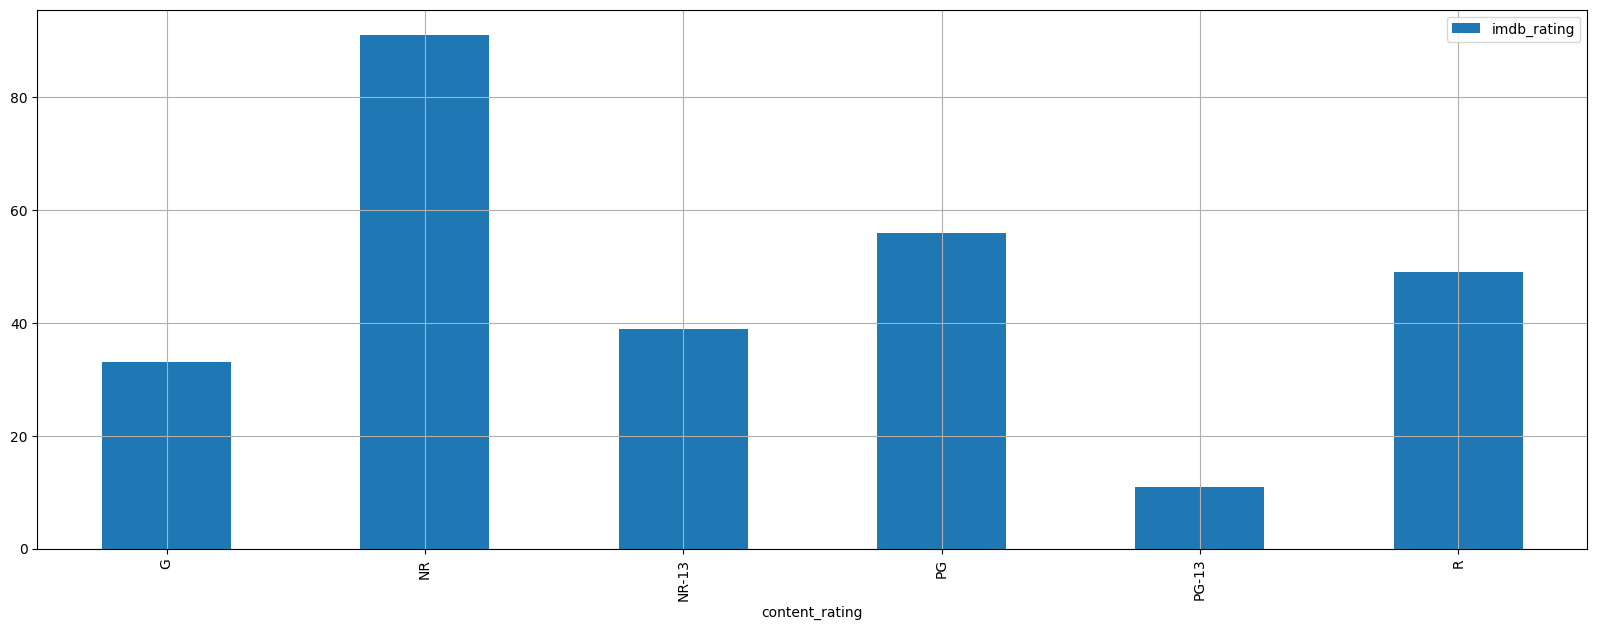

In [40]:
imdb_rating.plot(grid=True, figsize=(20, 7), kind = 'bar', x='content_rating',y='imdb_rating')

Рейтинг зависит от: </br>
1) Года выпуска </br>
2) Оскара </br>
3) Рейтинга на tomatometer
4) Рейтинга публики
5) Хороших рецензий критиков на tomatometer

In [41]:
NR = data_filtered.query('content_rating == "NR"')
PG = data_filtered.query('content_rating == "PG"')

Text(0.5, 1.0, 'PG')

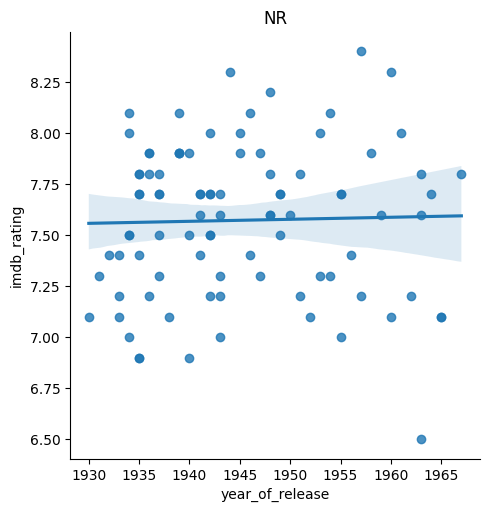

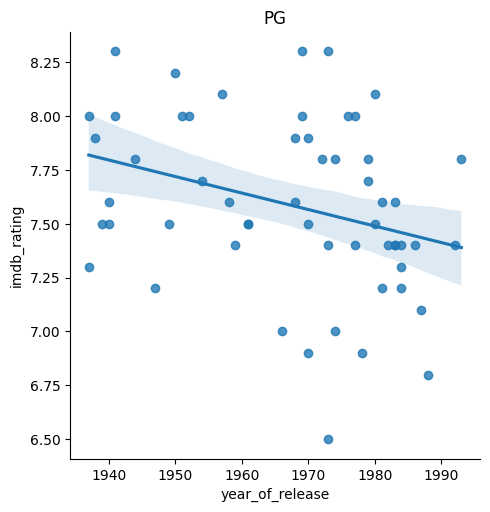

In [42]:
sns.lmplot(x="year_of_release", y="imdb_rating", data=NR)
plt.title('NR')
sns.lmplot(x="year_of_release", y="imdb_rating", data=PG)
plt.title('PG')

In [43]:
year_of_release_NR = NR[["year_of_release", "imdb_rating"]]
corr_NR = year_of_release_NR.corr()
year_of_release_PG = PG[["year_of_release", "imdb_rating"]]
corr_PG = year_of_release_PG.corr()

print(round(corr_NR, 3))
print(round(corr_PG, 3))

                 year_of_release  imdb_rating
year_of_release            1.000        0.026
imdb_rating                0.026        1.000
                 year_of_release  imdb_rating
year_of_release            1.000       -0.314
imdb_rating               -0.314        1.000


In [44]:
award_NR = NR[["award", "imdb_rating"]]
corr_NR = award_NR.corr()
award_PG = PG[["award", "imdb_rating"]]
corr_PG = award_PG.corr()

print(round(corr_NR, 3))
print(round(corr_PG, 3))

             award  imdb_rating
award        1.000        0.125
imdb_rating  0.125        1.000
             award  imdb_rating
award        1.000        0.185
imdb_rating  0.185        1.000


In [45]:
tomatometer_rating_NR = NR[["tomatometer_rating", "imdb_rating"]]
corr_NR = tomatometer_rating_NR.corr()
tomatometer_rating_PG = PG[["tomatometer_rating", "imdb_rating"]]
corr_PG = tomatometer_rating_PG.corr()

print(round(corr_NR, 3))
print(round(corr_PG, 3))

                    tomatometer_rating  imdb_rating
tomatometer_rating               1.000        0.447
imdb_rating                      0.447        1.000
                    tomatometer_rating  imdb_rating
tomatometer_rating               1.000        0.558
imdb_rating                      0.558        1.000


In [46]:
audience_rating_NR = NR[["audience_rating", "imdb_rating"]]
corr_NR = audience_rating_NR.corr()
audience_rating_PG = PG[["audience_rating", "imdb_rating"]]
corr_PG = audience_rating_PG.corr()

print(round(corr_NR, 3))
print(round(corr_PG, 3))

                 audience_rating  imdb_rating
audience_rating            1.000        0.894
imdb_rating                0.894        1.000
                 audience_rating  imdb_rating
audience_rating            1.000        0.903
imdb_rating                0.903        1.000


In [47]:
tomatometer_fresh_critics_count_NR = NR[["tomatometer_fresh_critics_count", "imdb_rating"]]
corr_NR = tomatometer_fresh_critics_count_NR.corr()
tomatometer_fresh_critics_count_PG = PG[["tomatometer_fresh_critics_count", "imdb_rating"]]
corr_PG = tomatometer_fresh_critics_count_PG.corr()

print(round(corr_NR, 3))
print(round(corr_PG, 3))

                                 tomatometer_fresh_critics_count  imdb_rating
tomatometer_fresh_critics_count                            1.000        0.629
imdb_rating                                                0.629        1.000
                                 tomatometer_fresh_critics_count  imdb_rating
tomatometer_fresh_critics_count                             1.00         0.54
imdb_rating                                                 0.54         1.00


In [50]:
NR['film_studio_producer'].value_counts()

film_studio_producer
Metro-Goldwyn-Mayer                        16
Warner Bros.                                9
RKO Radio                                   9
Columbia                                    9
20th Century-Fox                            7
Samuel Goldwyn Productions                  4
Cosmopolitan                                2
Paramount                                   2
William Wyler                               2
Stanley Kramer                              2
Hal Roach (production company)              1
Joseph Janni                                1
Michael Cacoyannis                          1
Ralph Nelson                                1
Elia Kazan                                  1
Tony Richardson                             1
Aaron Rosenberg                             1
Robert Rossen                               1
Fred Zinnemann                              1
Billy Wilder                                1
Henry Blanke                                1
Jack L. Warne

In [51]:
PG['film_studio_producer'].value_counts()

film_studio_producer
Stanley Kramer                                           3
Metro-Goldwyn-Mayer                                      2
Warner Bros.-First National                              2
Warner Bros.                                             2
20th Century-Fox                                         2
Peter Yates                                              2
Sydney Pollack and Dick Richards                         1
Charles H. Joffe                                         1
Ray Stark                                                1
Warren Beatty                                            1
Stanley R. Jaffe                                         1
Bernard Schwartz                                         1
Jonathan Sanger                                          1
David Puttnam                                            1
Bruce Gilbert                                            1
Philip S. Hobel                                          1
James L. Brooks                    

Text(0.5, 1.0, 'NR')

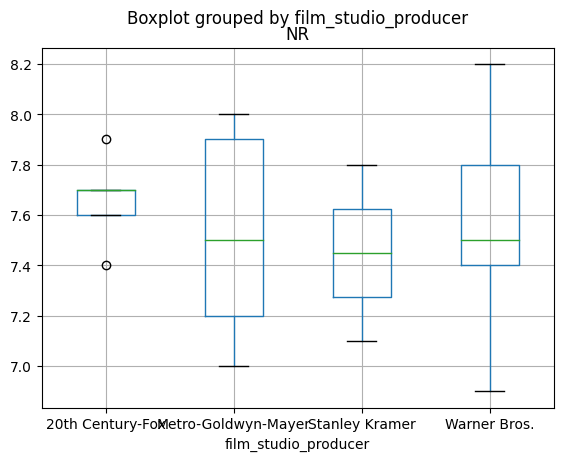

In [58]:
filter_prod_NR = NR.query('film_studio_producer == ["Stanley Kramer", "Metro-Goldwyn-Mayer", "Warner Bros.", "20th Century-Fox"]')
filter_prod_NR.boxplot(by ='film_studio_producer', column ='imdb_rating', grid = True)
plt.title('NR')

Text(0.5, 1.0, 'PG')

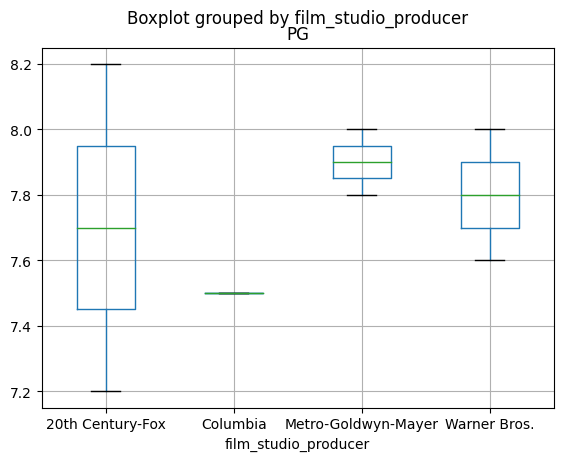

In [57]:
filter_prod_PG = PG.query('film_studio_producer == ["Metro-Goldwyn-Mayer", "Warner Bros.", "Columbia", "20th Century-Fox"]')
filter_prod_PG.boxplot(by ='film_studio_producer', column ='imdb_rating', grid = True)
plt.title('PG')